# Computer Vision: scikit-image + scikit-learn

![](python-logo.png)
![](logo.png)
![](scikit-learn-logo-small.png)

# Problema: 
## Classificar Imagens da Retina
#### *Com Retinopatia* 

#### *Sem Retinopatia*


In [2]:
import numpy as np
from numpy import copy
import matplotlib.pyplot as plt
from skimage.io import imread_collection,imsave
from sklearn.model_selection import train_test_split
from glob import glob
from scipy.stats import randint as sp_randint
import time
from skimage.color import rgb2grey
from skimage.filters import threshold_otsu
from skimage.measure import label,regionprops
import copy
from scipy.stats import skew, kurtosis
from IPython.display import clear_output
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore")


#%matplotlib inline

#%matplotlib widget
#%matplotlib notebook
%matplotlib inline


# Read images from database

In [9]:
path = "../RIMONE-db-r2/"

In [10]:
benigno = glob(path+'benigno/*.jpg')

In [11]:
print('A base de imagens da retina possui {} exemplos benignos.'.format(len(benigno)))

A base de imagens da retina possui 255 exemplos benignos.


In [12]:
maligno = glob(path+'maligno/*.jpg')

In [13]:
print('A base de imagens da retina possui {} exemplos malignos.'.format(len(maligno)))

A base de imagens da retina possui 200 exemplos malignos.


In [14]:
images = imread_collection(benigno+maligno)

Text(0.5, 1.0, 'Exemplo de imagem da base')

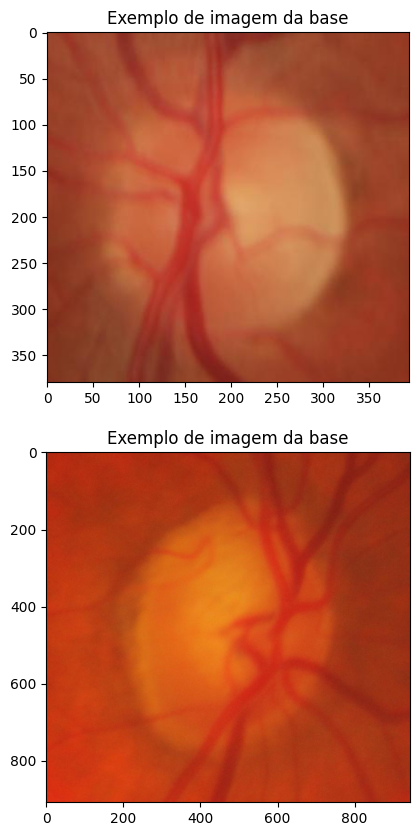

In [15]:
fig, ax = plt.subplots(2,1,figsize=(10,10))
ax[0].imshow(images[0])
ax[0].set_title('Exemplo de imagem da base')
ax[1].imshow(images[350])
ax[1].set_title('Exemplo de imagem da base')

In [16]:
labels = np.concatenate((np.zeros(len(benigno)),np.ones(len(maligno))))
labels

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

# Extracting Features using GLCM

In [17]:
from skimage.feature import greycomatrix,greycoprops

### Parameter

- Distance
- Angle

In [18]:
d = 2

In [19]:
features = np.zeros((len(labels),18)) #6 features x 3 color channels
start = time.time()

for id_im,imagem in enumerate(images):
    clear_output(wait=True)
    print('Extraindo atributos: {} imagens processadas de {}.'.format(id_im+1,len(images)))
    for id_ch in range(3):
        matrix0 = greycomatrix(imagem[:,:,id_ch], [d], [0],normed=True)
        matrix1 = greycomatrix(imagem[:,:,id_ch], [d], [np.pi/4],normed=True)
        matrix2 = greycomatrix(imagem[:,:,id_ch], [d], [np.pi/2],normed=True)
        matrix3 = greycomatrix(imagem[:,:,id_ch], [d], [3*np.pi/4],normed=True)
        matrix = (matrix0+matrix1+matrix2+matrix3)/4 
        props = np.zeros((6))
        props[0] = greycoprops(matrix,'contrast')
        props[1] = greycoprops(matrix,'dissimilarity')
        props[2] = greycoprops(matrix,'homogeneity')
        props[3] = greycoprops(matrix,'energy')
        props[4] = greycoprops(matrix,'correlation')
        props[5] = greycoprops(matrix,'ASM')
        features[id_im,id_ch*6:(id_ch+1)*6] = props

end = time.time()
print(end - start)

Extraindo atributos: 455 imagens processadas de 455.
45.7330379486084


# Visualizando os atributos

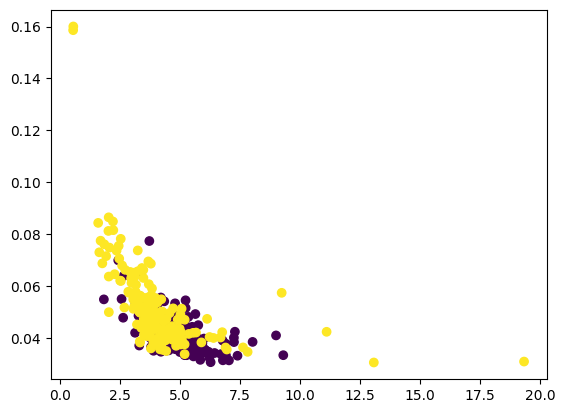

In [25]:
plt.scatter(features[:,0],features[:,3],c=labels)

In [26]:
pca = PCA()
pca.fit(features)
transform = pca.transform(features)
print(np.sum(pca.explained_variance_ratio_[0:3]))

0.9973185322472015


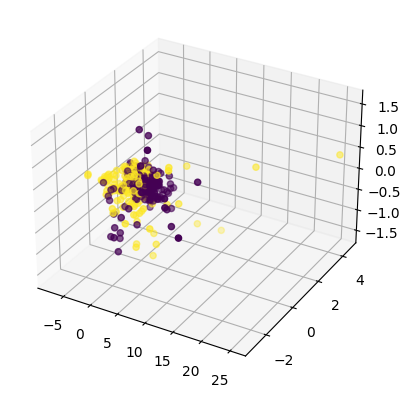

In [27]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(transform[:,0],transform[:,1],transform[:,2],c=labels)

# Classification

- Dividir o espaço de atributos em regiões;
- A quantidade de regiões é o número de classes;
- A acurácia da classificação está diretamente liga à qualidade dos atributos.

### Split Data

In [104]:
train = 0.9
test = 1-train

In [96]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=test)

### Train/Test

In [59]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import cohen_kappa_score, make_scorer, confusion_matrix,accuracy_score
from sklearn.svm import SVC

In [97]:
c_rf = RandomForestClassifier()
c_rf.fit(X_train,y_train)
pred = c_rf.predict(X_test)
acc_rf = accuracy_score(y_test, pred)
print('Accuracy Random Forest: {}'.format(acc_rf))

Accuracy Random Forest: 0.7912087912087912


### Computing standard deviation

In [105]:
acc_rf = []
c_rf = RandomForestClassifier()
for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=test)
    c_rf.fit(X_train,y_train)
    pred = c_rf.predict(X_test)
    acc_rf.append(accuracy_score(y_test, pred))
print("Mean accuracy Random Forest: {}+-{}".format(np.mean(acc_rf),np.std(acc_rf)))


Mean accuracy Random Forest: 0.7908695652173913+-0.057989308707602584


### Random Forest Parameter Estimation

In [74]:

def rf_parameter_estimation(xEst, yEst):
    
    clf = RandomForestClassifier(n_estimators=20)    
    # specify parameters and distributions to sample from
    hyperparameters = {"n_estimators": range(10,1000,50),
                  "max_depth": range(1,100),
                  "max_features": sp_randint(1, xEst.shape[1]),
                  "min_samples_split": sp_randint(2, xEst.shape[1]),
                  "min_samples_leaf": sp_randint(1, xEst.shape[1]),
                  "bootstrap": [True, False],
                  "criterion": ["gini", "entropy"]}
    
    
    # run randomized search
    n_iter_search = 20
    random_search = RandomizedSearchCV(clf, param_distributions=hyperparameters,
                                       n_iter=n_iter_search,scoring=make_scorer(accuracy_score))
    
    
    random_search.fit(xEst, yEst)
    report(random_search.cv_results_)
    return random_search.best_params_

def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))

# Classification unsing all features

In [106]:
start = time.time()

parameters = rf_parameter_estimation(X_train, y_train)
c_rf = RandomForestClassifier(**parameters)
c_rf.fit(X_train,y_train)
pred = c_rf.predict(X_test)
acc_rf = accuracy_score(y_test, pred)

end = time.time()
print(end - start)

Model with rank: 1
Mean validation score: 0.812 (std: 0.037)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 57, 'max_features': 9, 'min_samples_leaf': 8, 'min_samples_split': 7, 'n_estimators': 410}
Model with rank: 2
Mean validation score: 0.802 (std: 0.032)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 37, 'max_features': 17, 'min_samples_leaf': 7, 'min_samples_split': 12, 'n_estimators': 560}
Model with rank: 2
Mean validation score: 0.802 (std: 0.032)
Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 85, 'max_features': 5, 'min_samples_leaf': 5, 'min_samples_split': 15, 'n_estimators': 160}
59.52846312522888


In [107]:
print('Random Forest Accuracy: ',acc_rf)

Random Forest Accuracy:  0.7391304347826086


# Classification using PCA

In [117]:
components = [6,8,10,12]

In [118]:
def pca(X_train, X_test,y_train, n_comp):
    """
    PCA transformation for using a 'training' set and a 'testing' set
    """
    pca = PCA(n_components=n_comp)
    pca.fit(X_train,y_train)
    transform = pca.transform(X_test)
    return transform

In [119]:
results_rf = np.zeros(5)

start = time.time()
for id_comp,comp in enumerate(components):
    
    print('-------------','n comp. = ',comp,'-------------')
    
    X_train_pca = pca(X_train,X_train,y_train,comp)
    
    X_test_pca = pca(X_train,X_test,y_train,comp)
    
    #RF
    parameters = rf_parameter_estimation(X_train_pca, y_train)
    c_rf = RandomForestClassifier(**parameters)
    c_rf.fit(X_train_pca,y_train)
    pred = c_rf.predict(X_test_pca)
    acc = accuracy_score(y_test, pred)
    results_rf[id_comp] = acc
    
    
end = time.time()
print(end - start)

------------- n comp. =  6 -------------
Model with rank: 1
Mean validation score: 0.807 (std: 0.021)
Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 16, 'max_features': 2, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 960}
Model with rank: 2
Mean validation score: 0.802 (std: 0.033)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 62, 'max_features': 1, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 660}
Model with rank: 3
Mean validation score: 0.797 (std: 0.029)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 9, 'max_features': 4, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 610}
------------- n comp. =  8 -------------
Model with rank: 1
Mean validation score: 0.829 (std: 0.015)
Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': 33, 'max_features': 1, 'min_samples_leaf': 4, 'min_samples_split': 6, 'n_estimators': 710}
Model with rank: 1
Mean validation s

In [ ]:
plt.style.use('ggplot')
fig = plt.figure(figsize = (10,5),dpi=400)
ax = plt.subplot(111)
ax.plot(range(1,7),np.concatenate((results_rf,[acc_rf]),axis=0),marker = 'D',linestyle = ':',label = 'Random Forest')
ax.set_xlim([0,7])
ax.set_xlabel('PCA Components')
ax.set_ylabel('Accuracy')
ax.set_xticks(range(1,7))
ax.set_xticklabels(['6','8','10','12','No PCA'])
ax.set_ylim([0.5,1])
ax.set_title('Helmets')

In [ ]:
fig.savefig('/Users/romuere/pca.png')

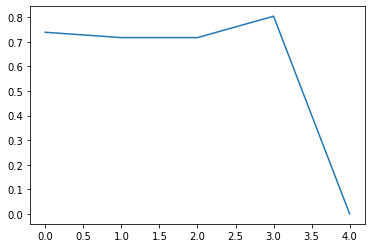

In [120]:
plt.plot(results_rf)

In [121]:
results_rf

array([0.73913043, 0.7173913 , 0.7173913 , 0.80434783, 0.        ])